# Task 1: AdaBoost and Random Forest Classifier for Customer Churn Dataset

In [15]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import psutil
import os

In [16]:
csv_file_path = "C:\\Users\\AMAN\\Desktop\\DMML Assignments\\Assignment 1 by Aman and Salokya Deb\\Task-1\\customer-churn-data.csv"
data = pd.read_csv(csv_file_path)

In [17]:
# Checking for missing values
missing_values = data.isnull().sum()
data_types = data.dtypes

info_table = pd.DataFrame({'Missing Values': missing_values, 'Data Types': data_types})
info_table = info_table.apply(lambda x: x.astype(str).str.center(15))
info_table.columns = info_table.columns.str.center(15)

print(info_table)

                       Missing Values     Data Types  
CustomerID                   0              int64     
Age                          0              int64     
Gender                       0              object    
AnnualIncome                 0             float64    
TotalSpend                   0             float64    
YearsAsCustomer              0              int64     
NumOfPurchases               0              int64     
AvgTransactionAmount         0             float64    
NumOfReturns                 0              int64     
NumOfSupportQueries          0              int64     
SatisfactionScore            0              int64     
LastPurchaseDaysAgo          0              int64     
EmailOptIn                   0               bool     
PromotionResponse            0              object    
Churn                        0               bool     


In [18]:
# CustomerID is not needed for classification
data = data.drop(data.columns[0], axis=1)

In [19]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# For optimal hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import train_test_split function
from sklearn.model_selection import train_test_split

# For categorical data
from sklearn.preprocessing import OneHotEncoder

# Import module for handling column transformations in the machine learning pipeline
from sklearn.compose import ColumnTransformer

# Import necessary modules for creating a machine learning pipeline
from sklearn.pipeline import Pipeline

# Import scikit-learn metrics module for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [20]:
start = time.time()

X = data.drop('Churn', axis=1) # Features
y = data['Churn'] # Target Variable

# Identifying categorical and boolean columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
boolean_cols = [col for col in X.columns if X[col].dtype == 'bool']

# Transformer for categorical columns
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', X.select_dtypes(include=['int64', 'float64']).columns),
        ('bool', 'passthrough', boolean_cols),  # No need for preprocessing boolean columns
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

end = time.time()
preprocessing_time = end-start


## Classifier using Adaboost

### AdaBoostClassifier with Decision Tree (Default)

In [21]:
start = time.time()

adaboost_clf = AdaBoostClassifier(n_estimators = 50)

# Creating and fitting the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', adaboost_clf)])

# Defining the parameter grid for AdaBoostClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__estimator': [None],
    'classifier__algorithm': ['SAMME', 'SAMME.R']
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Initial memory usage
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Memory usage after fitting
memory_after = process.memory_info().rss

# Memory consumed
memory_consumed_ada_dt = (memory_after - memory_before)/1024

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)

# Predictions on test data
y_pred_ada_dt = grid_search.predict(X_test)
end = time.time()

# Predictions on training data
y_train_pred_ada_dt = grid_search.predict(X_train)

run_time_ada_dt = (end-start)+preprocessing_time

Best parameters found:  {'classifier__algorithm': 'SAMME', 'classifier__estimator': None, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}


### Evaluation Metrics

In [22]:
# Evaluating performance metrics
accuracy_train_ada_dt = accuracy_score(y_train,y_train_pred_ada_dt)
accuracy_ada_dt = accuracy_score(y_test, y_pred_ada_dt)
precision_ada_dt = precision_score(y_test, y_pred_ada_dt)
recall_ada_dt = recall_score(y_test, y_pred_ada_dt)
f1score_ada_dt = f1_score(y_test, y_pred_ada_dt)
print(f'Training Data Accuracy Score: {accuracy_train_ada_dt:.2f}')
print(f'Test Data Accuracy Score: {accuracy_ada_dt:.2f}')
print(f'Test Data Precision Score: {precision_ada_dt:.2f}')
print(f'Test Data Recall Score: {recall_ada_dt:.2f}')
print(f'Test Data F1 Score: {f1score_ada_dt:.2f}')

# Confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred_ada_dt)

print('\nConfusion Matrix:')
print(conf_matrix)

Training Data Accuracy Score: 0.54
Test Data Accuracy Score: 0.53
Test Data Precision Score: 0.53
Test Data Recall Score: 1.00
Test Data F1 Score: 0.69

Confusion Matrix:
[[  0  94]
 [  0 106]]


### AdaBoostClassifier with RandomForestClassifier

In [23]:
start = time.time()
# Making the RandomForestClassifier
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)

# Making the AdaBoostClassifier with RandomForestClassifier as base estimator
adaboost_clf = AdaBoostClassifier(base_estimator=rf_base, random_state=42)

# Creating the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', adaboost_clf)])

# Defining the parameter grid for AdaBoostClassifier
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__base_estimator__max_depth': [None, 5, 10]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Get the initial memory usage
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the memory usage after fitting
memory_after = process.memory_info().rss

# Calculate the memory consumed
memory_consumed_ada_rf = (memory_after - memory_before)/1024

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)

# Predictions on test data
y_pred_ada_rf = grid_search.predict(X_test)
end = time.time()

# Predictions on training data
y_train_pred_ada_rf = grid_search.predict(X_train)

run_time_ada_rf = (end-start)+preprocessing_time

c:\Users\AMAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best parameters found:  {'classifier__base_estimator__max_depth': 10, 'classifier__learning_rate': 0.01, 'classifier__n_estimators': 50}


### Evaluation Metrics

In [24]:
# Evaluating performance metrics
accuracy_train_ada_rf = accuracy_score(y_train,y_train_pred_ada_rf)
accuracy_ada_rf = accuracy_score(y_test, y_pred_ada_rf)
precision_ada_rf = precision_score(y_test, y_pred_ada_rf)
recall_ada_rf = recall_score(y_test, y_pred_ada_rf)
f1score_ada_rf = f1_score(y_test, y_pred_ada_rf)
print(f'Training Data Accuracy Score: {accuracy_train_ada_rf:.2f}')
print(f'Test Data Accuracy Score: {accuracy_ada_rf:.2f}')
print(f'Test Data Precision Score: {precision_ada_rf:.2f}')
print(f'Test Data Recall Score: {recall_ada_rf:.2f}')
print(f'Test Data F1 Score: {f1score_ada_rf:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ada_rf)

print('\nConfusion Matrix:')
print(conf_matrix)

Training Data Accuracy Score: 1.00
Test Data Accuracy Score: 0.52
Test Data Precision Score: 0.53
Test Data Recall Score: 0.65
Test Data F1 Score: 0.59

Confusion Matrix:
[[34 60]
 [37 69]]


## Classifier using Random Forest

### Training the Random Forest Classifier and making predictions

In [11]:
start = time.time()

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 150, 200],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'classifier__bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
}

# Making the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Creating the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', rf_clf)])

# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Initial memory usage
process = psutil.Process(os.getpid())
memory_before = process.memory_info().rss

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Memory usage after fitting
memory_after = process.memory_info().rss

# Memory consumed
memory_consumed_rf = (memory_after - memory_before)/1024

# Best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Predict the response variable on the test set
best_model = grid_search.best_estimator_
y_pred_rf = best_model.predict(X_test)

end = time.time()

# Predictions on training data
y_train_pred_rf = grid_search.predict(X_train)

run_time_rf = (end-start)+preprocessing_time

Best parameters found:
{'classifier__bootstrap': False, 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


### Evaluation Metrics

In [12]:
# Evaluate performance metrics
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1score_rf = f1_score(y_test, y_pred_rf)
print(f'Training Data Accuracy Score: {accuracy_train_rf:.2f}')
print(f'Test Data Accuracy Score: {accuracy_rf:.2f}')
print(f'Test Data Precision Score: {precision_rf:.2f}')
print(f'Test Data Recall Score: {recall_rf:.2f}')
print(f'Test Data F1 Score: {f1score_rf:.2f}')

# Confusion matrix 
conf_matrix = confusion_matrix(y_test, y_pred_rf)

print('\nConfusion Matrix:')
print(conf_matrix)

Training Data Accuracy Score: 1.00
Test Data Accuracy Score: 0.51
Test Data Precision Score: 0.53
Test Data Recall Score: 0.63
Test Data F1 Score: 0.58

Confusion Matrix:
[[34 60]
 [39 67]]


## Comparative Evaluation

### Comparison of Performance Metrics

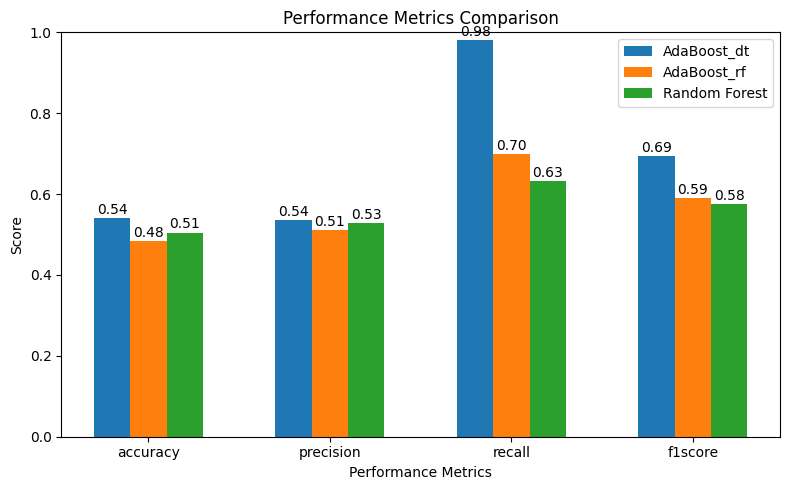

In [13]:
# Sample data for three models
Performance_Metrics = ['accuracy', 'precision', 'recall', 'f1score']
AdaBoost_dt = [accuracy_ada_dt, precision_ada_dt,recall_ada_dt, f1score_ada_dt]
AdaBoost_rf = [accuracy_ada_rf, precision_ada_rf,recall_ada_rf, f1score_ada_rf]
Random_Forest = [accuracy_rf, precision_rf, recall_rf, f1score_rf]

bar_width = 0.2

index = np.arange(len(Performance_Metrics))

plt.figure(figsize=(8, 5))
plt.bar(index - 1.0*bar_width, AdaBoost_dt, bar_width, label='AdaBoost_dt')
plt.bar(index , AdaBoost_rf, bar_width, label='AdaBoost_rf')
plt.bar(index + 1.0*bar_width, Random_Forest, bar_width, label='Random Forest')

for i in range(len(Performance_Metrics)):
    plt.text(index[i] - 1*bar_width, AdaBoost_dt[i] + 0.01, f'{AdaBoost_dt[i]:.2f}', ha='center')
    plt.text(index[i], AdaBoost_rf[i] + 0.01, f'{AdaBoost_rf[i]:.2f}', ha='center')
    plt.text(index[i] + 1*bar_width, Random_Forest[i] + 0.01, f'{Random_Forest[i]:.2f}', ha='center')

plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(index, Performance_Metrics)
plt.legend()

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


### Comparison of Run Times and Memory Used

In [14]:
metrics_dict = {
    'Model Type': ['Adaboost (decision trees)','Adaboost(random forest)','Random Forest'],
    'Run Time': [run_time_ada_dt, run_time_ada_rf, run_time_rf],
    'Memory Used (in KB)': [memory_consumed_ada_dt, memory_consumed_ada_rf, memory_consumed_rf]
}

metrics_df = pd.DataFrame(metrics_dict)

table = tabulate(metrics_df, headers='keys', tablefmt='pretty', showindex=False)

print(table)


+---------------------------+-------------------+---------------------+
|        Model Type         |     Run Time      | Memory Used (in KB) |
+---------------------------+-------------------+---------------------+
| Adaboost (decision trees) | 9.556113719940186 |       1200.0        |
|  Adaboost(random forest)  | 539.8581728935242 |       43524.0       |
|       Random Forest       | 636.2342970371246 |       6704.0        |
+---------------------------+-------------------+---------------------+
